# scikit-learn与svm
作者：[寒小阳](http://blog.csdn.net/han_xiaoyang)<br>
日期：2016年7月

主要介绍以下2个方面的内容

* 支持向量机分类器
* 支持向量机与核函数

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn; 
from sklearn.linear_model import LinearRegression
from scipy import stats
import pylab as pl
seaborn.set()

## 支持向量机分类器

支持向量机是解决**分类** 和 **回归** 问题非常强大的有监督学习算法。简单说来，linear的SVM做的事情就是在不同类别的“数据团”之间划上一条线，用以分界，但是只划线是远远不够的，SVM试图找到一条最健壮的线，什么叫做最健壮的线？其实就是离2类样本点最远的线。

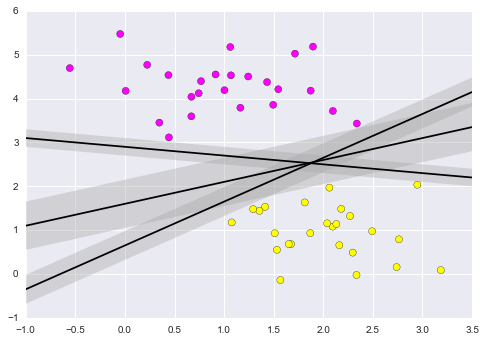

In [7]:
from sklearn.datasets.samples_generator import make_blobs
# make_blobs: Generate isotropic Gaussian blobs for clustering
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)

# np.linspace: Return evenly spaced numbers over a specified interval
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')


# 其实随意给定3组参数，就可以画出3条不同的直线，但它们都可以把图上的2类样本点分隔开
for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none', color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

Fit the model:

In [8]:
from sklearn.svm import SVC
clf = SVC(kernel='linear')
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

画出决策边界：

In [8]:
def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([xi, yj])
    # plot the margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

sklearn的SVM里面会有一个属性``support_vectors_``，标示“支持向量”，也就是样本点里离超平面最近的点，组成的。<br>
咱们来画个图，把超平面和支持向量都画出来。

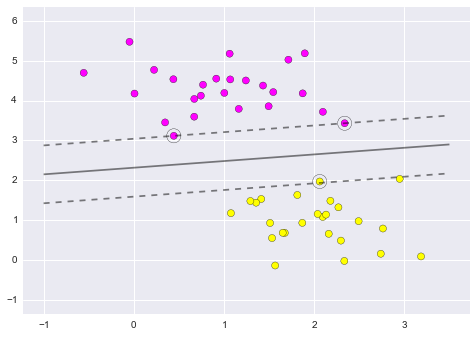

In [9]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=200, facecolors='none');

可以用IPython的``interact``函数来看看样本点的分布，会怎么样影响超平面:

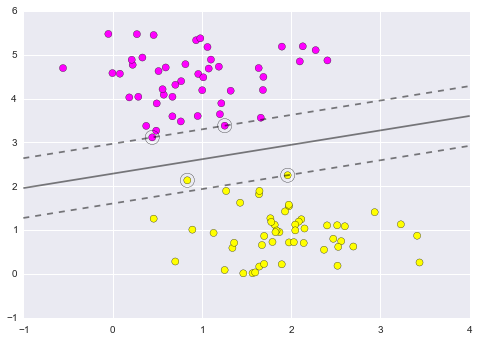

In [10]:
from IPython.html.widgets import interact

def plot_svm(N=100):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    clf = SVC(kernel='linear')
    clf.fit(X, y)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
    plt.xlim(-1, 4)
    plt.ylim(-1, 6)
    plot_svc_decision_function(clf, plt.gca())
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                s=200, facecolors='none')
    
interact(plot_svm, N=[10, 200], kernel='linear');

## 支持向量机与核函数

对于非线性可切分的数据集，要做分割，就要借助于**核函数**了<br>
简单一点说呢，核函数可以看做对原始特征的一个映射函数，不过SVM不会傻乎乎对原始样本点做映射，它有更巧妙的方式来保证这个过程的高效性。<br>
下面有一个例子，你可以看到，线性的kernel(线性的SVM)对于这种非线性可切分的数据集，是无能为力的。

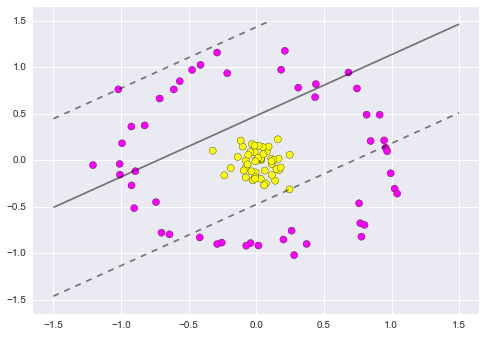

In [11]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf);

然后强大的**高斯核/radial basis function**就可以大显身手了:

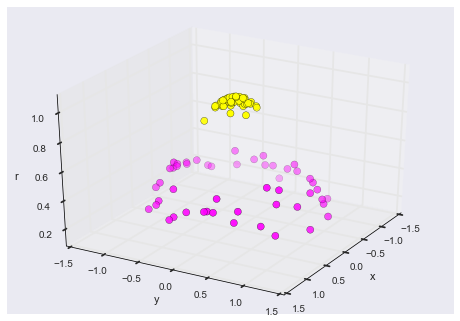

In [12]:
r = np.exp(-(X[:, 0] ** 2 + X[:, 1] ** 2))

from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='spring')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180));

你在上面的图上也可以看到，原本在2维空间无法切分的2类点，映射到3维空间以后，可以由一个平面轻松地切开了。<br>
而带rbf核的SVM就能帮你做到这一点:

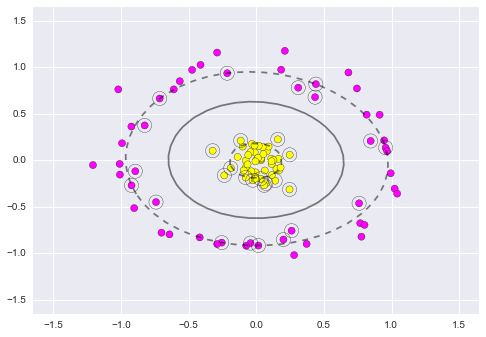

In [13]:
clf = SVC(kernel='rbf')
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=200, facecolors='none');

关于SVM的一些额外的小贴士:
* 除掉我们说的核函数选择，你在使用SVM的时候，一定要注意合适的参数设置，比如sklearn里面的c和gamma。你可以借助于交叉验证，在交叉验证集上选出效果最好的参数。
* 很遗憾的是，SVM是O(n^3)的时间复杂度。在sklearn里，LinearSVC是可扩展的(也就是对海量数据也可以支持得不错), 对特别大的数据集SVC就略微有点尴尬了。不过对于特别大的数据集，你倒是可以试试采样一些样本出来，然后用rbf核的SVC来做做分类。

## SVM: Weighted samples
Plot decision function of a weighted dataset, where the size of points is proportional to its weight.
The sample weighting rescales the C parameter, which means that the classifier puts more emphasis on getting these points right. The effect might often be subtle. To emphasize the effect here, we particularly weight outliers, making the deformation of the decision boundary very visible.


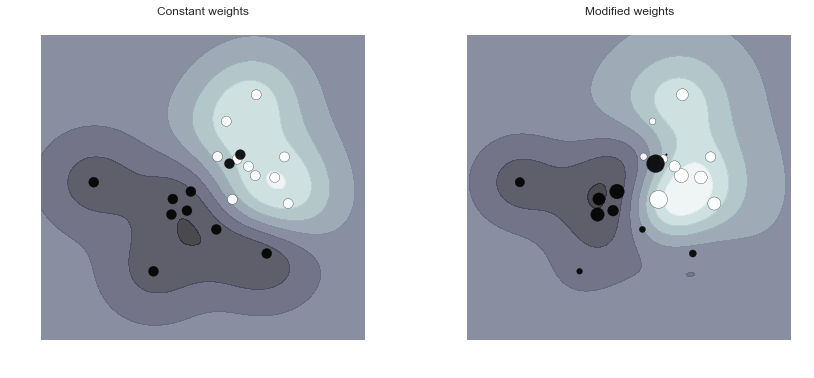

In [10]:
from sklearn import svm

def plot_decision_function(classifier, sample_weight, axis, title):
    # plot the decision function
    xx, yy = np.meshgrid(np.linspace(-4, 5, 500), np.linspace(-4, 5, 500))

    Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # plot the line, the points, and the nearest vectors to the plane
    axis.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.bone)
    axis.scatter(X[:, 0], X[:, 1], c=Y, s=100 * sample_weight, alpha=0.9,
                 cmap=plt.cm.bone)

    axis.axis('off')
    axis.set_title(title)


# we create 20 points
np.random.seed(0)
X = np.r_[np.random.randn(10, 2) + [1, 1], np.random.randn(10, 2)]
Y = [1] * 10 + [-1] * 10
sample_weight_last_ten = abs(np.random.randn(len(X)))
sample_weight_constant = np.ones(len(X))
# and bigger weights to some outliers
sample_weight_last_ten[15:] *= 5
sample_weight_last_ten[9] *= 15

# for reference, first fit without class weights

# fit the model
clf_weights = svm.SVC()
clf_weights.fit(X, Y, sample_weight=sample_weight_last_ten)

clf_no_weights = svm.SVC()
clf_no_weights.fit(X, Y)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_decision_function(clf_no_weights, sample_weight_constant, axes[0],
                       "Constant weights")
plot_decision_function(clf_weights, sample_weight_last_ten, axes[1],
                       "Modified weights")

plt.show()